In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
from sklearn.preprocessing import scale as scaler
from sklearn.model_selection import KFold
import numpy.random as npr
import robust_loss_pytorch
from robust_loss_pytorch import distribution
import robust_loss_pytorch.general as general
import random
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Construct some regression data with some extreme outliers.
np.random.seed(1234)
torch.manual_seed(1234)

In [2]:
def train_regular(model, trX, trY, dist, learning_rate=0.01, epoch=500, verbose=True):

    params = list(model.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(dist.loss(y_hat, trY))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            # You can see the alpha+scale parameters moving around.
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model


def train_adaptive(model, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
        num_dims=1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
    params = list(model.parameters()) + list(adaptive.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(adaptive.lossfun((y_hat - trY)[:,None]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            e, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data))
    return model, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data


def train_locally_adaptive(model, alpha, scale, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    params = list(model.parameters()) + list(alpha.parameters()) + list(scale.parameters())
    dist = distribution.Distribution()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        alphas = torch.exp(alpha(trX))
        scales = torch.exp(scale(trX))
        loss = general.lossfun((y_hat - trY)[:, None], alpha=alphas, scale=scales, approximate=False)
        log_partition = torch.log(scales) + dist.log_base_partition_function(alphas)
        loss = (loss + log_partition).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model, alpha, scale


class PolyRegression(nn.Module):
    def __init__(self, dim, init_zeros=False):
        super(PolyRegression, self).__init__()
        self.beta = nn.Linear(dim, 1)
        self.n_poly = dim
        if init_zeros:
            with torch.no_grad():
                self.beta.weight.copy_(torch.zeros(dim))
                self.beta.bias.copy_(torch.zeros(1))

    def forward(self, x):
        """
        x: N x dim
        """
        expand = [(x**(i+1)).view(-1, 1) for i in range(self.n_poly)]
        expand = torch.cat(expand, dim=1)
        return self.beta(expand)


class AdaptiveRegression(nn.Module):
    def __init__(self):
        pass

    def forward(self, x):
        pass

In [3]:
class Gaussian(object):
    def loss(self, x, y):
        return (x-y)**2

    def loglikelihood(self, res, sigma=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if sigma is None:
            sigma = np.mean(res**2)
        N = len(res)
        ll = -N/2*np.log(2*np.pi*sigma) - 1/(2*sigma)*np.sum(res**2)
        return ll


class Laplace(object):
    def loss(self, x, y):
        return torch.abs(x-y)

    def loglikelihood(self, res, b=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if b is None:
            b = np.sqrt(np.mean(res ** 2)/2)
        N = len(res)
        ll = -N*np.log(2*b) - 1/b*np.sum(np.abs(res))
        return ll


class Adaptive(object):
    def loglikelihood(self, res, alpha, scale):
        assert alpha.view(-1).size()[0] == 1 or alpha.view(-1).size()[0] == len(res)
        N = len(res)
        dist = distribution.Distribution()
        loss = general.lossfun(res, alpha, scale, approximate=False).sum()
        log_partition = torch.log(scale) + dist.log_base_partition_function(alpha)
        if alpha.view(-1).size()[0] == 1:
            log_partition = N*log_partition
        else:
            log_partition = log_partition.sum()
        nll = loss + log_partition
        return -nll.detach().numpy()

    def sample(self, alpha, c):
        alpha = torch.as_tensor(alpha)
        scale = torch.as_tensor(c)
        assert (alpha >= 0).all()
        assert (scale >= 0).all()
        float_dtype = alpha.dtype
        assert scale.dtype == float_dtype

        cauchy = torch.distributions.cauchy.Cauchy(0., np.sqrt(2.))
        uniform = torch.distributions.uniform.Uniform(0, 1)
        samples = torch.zeros_like(alpha)
        accepted = torch.zeros(alpha.shape).type(torch.bool)
        dist = distribution.Distribution()
        while not accepted.type(torch.uint8).all():
            # Draw N samples from a Cauchy, our proposal distribution.
            cauchy_sample = torch.reshape(
              cauchy.sample((np.prod(alpha.shape),)), alpha.shape)
            cauchy_sample = cauchy_sample.type(alpha.dtype)

            # Compute the likelihood of each sample under its target distribution.
            nll = dist.nllfun(cauchy_sample,
                            torch.as_tensor(alpha).to(cauchy_sample),
                            torch.tensor(1).to(cauchy_sample))

            # Bound the NLL. We don't use the approximate loss as it may cause
            # unpredictable behavior in the context of sampling.
            nll_bound = general.lossfun(
              cauchy_sample,
              torch.tensor(0., dtype=cauchy_sample.dtype),
              torch.tensor(1., dtype=cauchy_sample.dtype),
              approximate=False) + dist.log_base_partition_function(alpha)

            # Draw N samples from a uniform distribution, and use each uniform sample
            # to decide whether or not to accept each proposal sample.
            uniform_sample = torch.reshape(
              uniform.sample((np.prod(alpha.shape),)), alpha.shape)
            uniform_sample = uniform_sample.type(alpha.dtype)
            accept = uniform_sample <= torch.exp(nll_bound - nll)

            # If a sample is accepted, replace its element in `samples` with the
            # proposal sample, and set its bit in `accepted` to True.
            samples = torch.where(accept, cauchy_sample, samples)
            accepted = accepted | accept

            # Because our distribution is a location-scale family, we sample from
            # p(x | 0, \alpha, 1) and then scale each sample by `scale`.
            samples *= scale
        return samples

In [4]:
# GP
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=1),
            ), grid_size=grid_size, num_dims=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Heteroskedastic data: LIDAR

c:\users\cecilia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


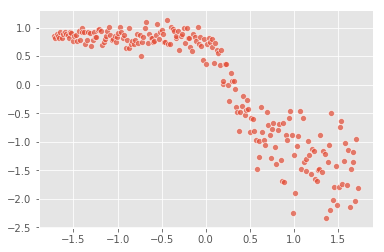

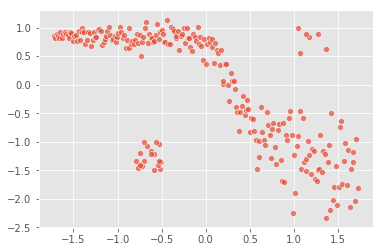

In [26]:
X = pd.read_csv('../dataset/lidar.tsv', sep='  ')
x_range = X['range']
y_ratio = X['logratio']

x_range = np.array((x_range-np.mean(x_range))/np.std(x_range))
y_ratio = np.array((y_ratio-np.mean(y_ratio))/np.std(y_ratio))
sns.scatterplot(x_range, y_ratio, alpha=0.7)
plt.show()

x_out1 = np.random.uniform(low=-0.8, high=-0.5, size=(20,))
y_out1 = np.random.uniform(low=-1.5, high=-1, size=(20,))
x_out2 = np.random.uniform(low=1, high=1.5, size=(6,))
y_out2 = np.random.uniform(low=0.5, high=1, size=(6,))

x_range_out = np.concatenate((x_range,x_out1), axis=0)
x_range_out = np.concatenate((x_range_out,x_out2), axis=0)
y_ratio_out = np.concatenate((y_ratio,y_out1), axis=0)
y_ratio_out = np.concatenate((y_ratio_out,y_out2), axis=0)
sns.scatterplot(x_range_out, y_ratio_out, alpha=0.7)

# Heteroskedastic data: MOTOR

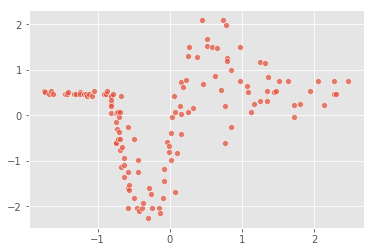

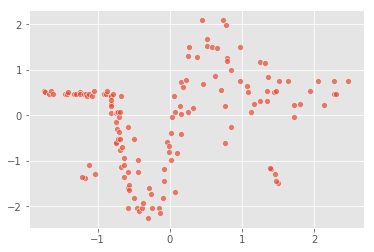

In [27]:
X = pd.read_csv('../dataset/mcycle.csv')
x_motor = X['times']
y_motor = X['accel']
x_motor = scaler(x_motor)
y_motor = scaler(y_motor)

x_out1 = np.random.uniform(low=-1.5, high=-1, size=(4,))
y_out1 = np.random.uniform(low=-1, high=-1.4, size=(4,))
x_out2 = np.random.uniform(low=1.3, high=1.5, size=(5,))
y_out2 = np.random.uniform(low=-1, high=-1.5, size=(5,))

x_motor_out = np.concatenate((x_motor,x_out1), axis=0)
x_motor_out = np.concatenate((x_motor_out,x_out2), axis=0)
y_motor_out = np.concatenate((y_motor,y_out1), axis=0)
y_motor_out = np.concatenate((y_motor_out,y_out2), axis=0)

sns.scatterplot(x_motor, y_motor, alpha=0.7)
plt.show()

sns.scatterplot(x_motor_out, y_motor_out, alpha=0.7)
plt.show()

In [81]:
dataset = 'lidar'   #'motor'
outliers = False

if dataset=='lidar':
    trXnoout, teXnoout, trYnoout, teYnoout = train_test_split(x_range, y_ratio, test_size=0.3, random_state=0)
    if outliers:
        x_range, y_ratio = x_range_out, y_ratio_out
    trX, teX, trY, teY = train_test_split(x_range, y_ratio, test_size=0.3, random_state=0)
    
elif dataset=='motor':
    trXnoout, teXnoout, trYnoout, teYnoout = train_test_split(x_motor, y_motor, test_size=0.3, random_state=0)
    if outliers:
        x_motor, y_motor = x_motor_out, y_motor_out
    trX, teX, trY, teY = train_test_split(x_motor, y_motor, test_size=0.3, random_state=0)

In [82]:
print(trX.shape, trY.shape)

(154,) (154,)


In [30]:
gaussian = Gaussian()
laplace = Laplace()
adaptive = Adaptive()

## Polynomial regression with regular, adaptive and locally adaptive

In [ ]:
x, y = torch.Tensor(trX), torch.Tensor(trY)
x_noout, y_noout = torch.Tensor(trXnoout), torch.Tensor(trYnoout)

# define regression degree
reg_degree = 5

# define regression model
lr = PolyRegression(reg_degree)

# regular loss training
reg_fit = train_regular(lr, x, y, gaussian, epoch=1000, learning_rate=1e-2, verbose=False)

# ada loss training
ada_fit, alpha, scale = train_adaptive(lr, x, y, learning_rate=0.01, epoch=500, verbose=False)

# adalocal loss training
alpha_model = PolyRegression(5, init_zeros=True)
scale_model = PolyRegression(5, init_zeros=True)
ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, x,y, learning_rate=0.01, epoch=500, verbose=False)

# 5-fold cross-validation for model degree

1


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 250.38it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -55.21278884154239
Laplace Log Likelihood:  -58.02169487753781
Adaptive Log Likelihood:  -20.844643
Ada+reg Log Likelihood :  -18.758846


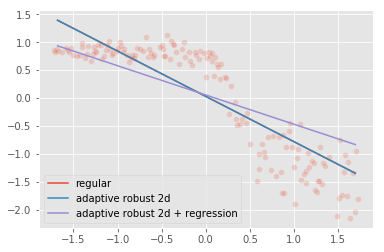

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 247.16it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -49.43403551276503
Laplace Log Likelihood:  -51.37791181591202
Adaptive Log Likelihood:  -18.531807
Ada+reg Log Likelihood :  -28.481346


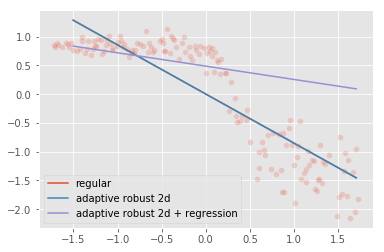

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 215.61it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -47.62104305532823
Laplace Log Likelihood:  -52.76918368850431
Adaptive Log Likelihood:  -26.061207
Ada+reg Log Likelihood :  -26.329157


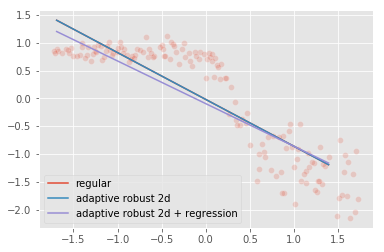

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 223.31it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -45.62879676606512
Laplace Log Likelihood:  -44.50019967370198
Adaptive Log Likelihood:  -19.033918
Ada+reg Log Likelihood :  -19.996515


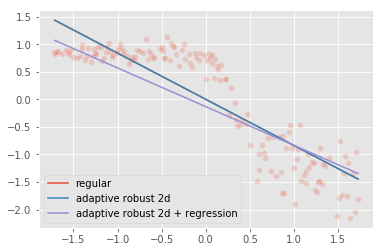

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 255.75it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -49.92210837329858
Laplace Log Likelihood:  -52.76707776544827
Adaptive Log Likelihood:  -22.36326
Ada+reg Log Likelihood :  -22.644205


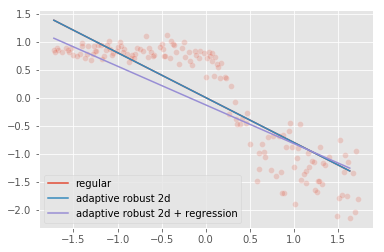

2


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 258.80it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -56.563943824851876
Laplace Log Likelihood:  -57.76706967596488
Adaptive Log Likelihood:  -14.4375515
Ada+reg Log Likelihood :  -2.8031292


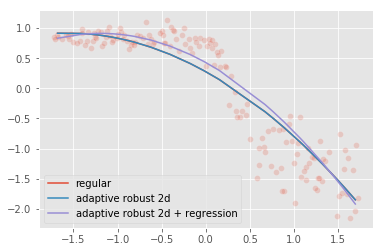

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 260.28it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -52.12204551322419
Laplace Log Likelihood:  -56.45088433783641
Adaptive Log Likelihood:  -20.43013
Ada+reg Log Likelihood :  -17.773996


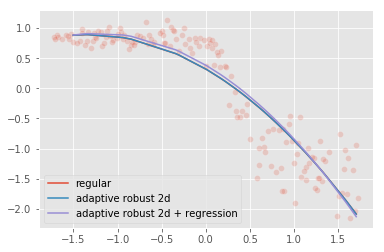

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 258.93it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -46.15704873635268
Laplace Log Likelihood:  -47.46132842008327
Adaptive Log Likelihood:  -19.20696
Ada+reg Log Likelihood :  -11.298265


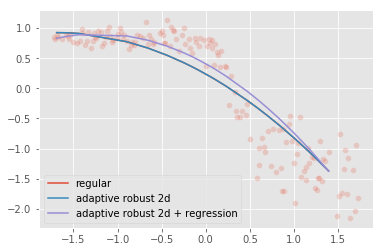

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 251.76it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -46.61696173187107
Laplace Log Likelihood:  -44.48878196872485
Adaptive Log Likelihood:  -13.924351
Ada+reg Log Likelihood :  0.3893757


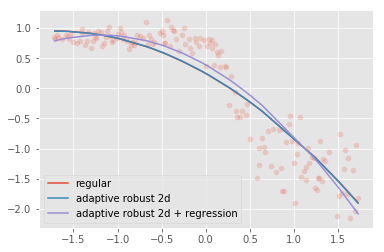

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 258.30it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -50.22435011065879
Laplace Log Likelihood:  -51.54269634340265
Adaptive Log Likelihood:  -16.60588
Ada+reg Log Likelihood :  -1.4424744


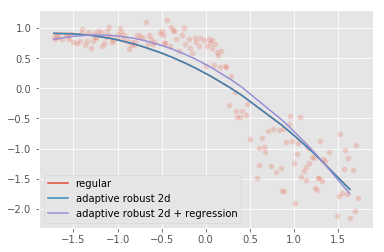

3


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 248.39it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -55.97572166170662
Laplace Log Likelihood:  -57.19683417790561
Adaptive Log Likelihood:  -14.201393
Ada+reg Log Likelihood :  -2.46212


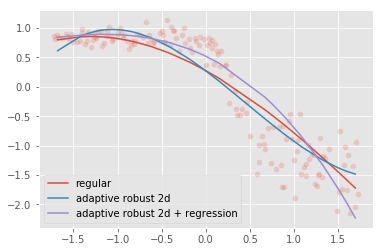

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 256.15it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -51.513931622139324
Laplace Log Likelihood:  -55.795609122817666
Adaptive Log Likelihood:  -16.5901
Ada+reg Log Likelihood :  -19.780396


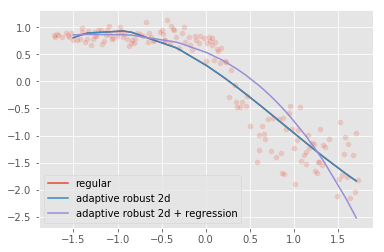

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 257.86it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -46.274276641904166
Laplace Log Likelihood:  -47.31312426210951
Adaptive Log Likelihood:  -17.131641
Ada+reg Log Likelihood :  -10.870841


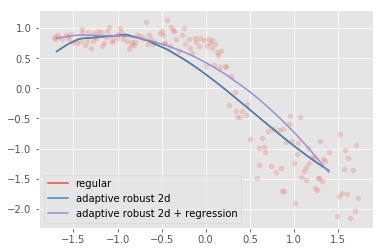

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 254.19it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -46.73491937253044
Laplace Log Likelihood:  -44.446399833140504
Adaptive Log Likelihood:  -7.9007363
Ada+reg Log Likelihood :  0.4161167


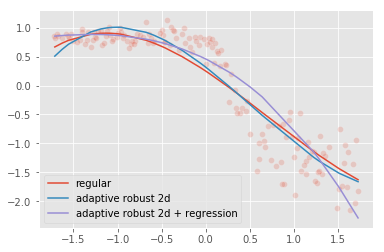

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 260.49it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -51.20551486792748
Laplace Log Likelihood:  -51.903197882469144
Adaptive Log Likelihood:  -13.781279
Ada+reg Log Likelihood :  -0.87350273


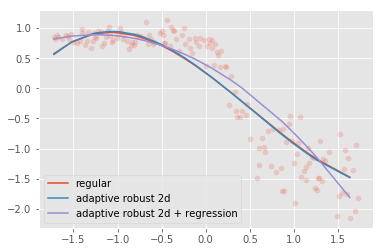

4


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 258.13it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -55.98136368951097
Laplace Log Likelihood:  -55.5628695190905
Adaptive Log Likelihood:  -13.386243
Ada+reg Log Likelihood :  -2.501625


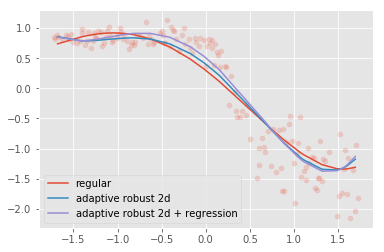

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 251.76it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -51.372101435645746
Laplace Log Likelihood:  -55.747265260642635
Adaptive Log Likelihood:  -14.410818
Ada+reg Log Likelihood :  -18.243917


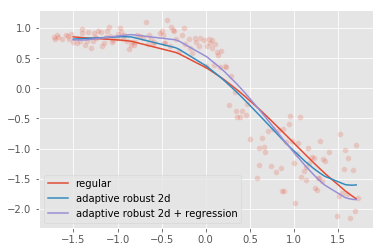

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 255.36it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -46.6304242093279
Laplace Log Likelihood:  -46.06188817452175
Adaptive Log Likelihood:  -14.119684
Ada+reg Log Likelihood :  -5.768629


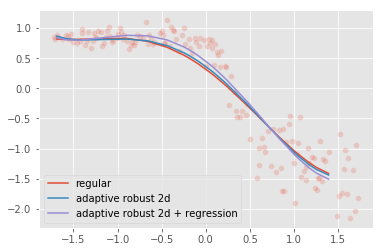

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 255.36it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -47.15871804782781
Laplace Log Likelihood:  -43.221510586936986
Adaptive Log Likelihood:  -10.713299
Ada+reg Log Likelihood :  4.1795025


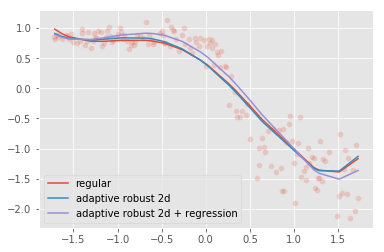

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 253.94it/s]


Polynomial degree  4
Gaussian Log Likelihood:  -52.089317637659846
Laplace Log Likelihood:  -52.8920111344623
Adaptive Log Likelihood:  -11.885287
Ada+reg Log Likelihood :  4.6972466


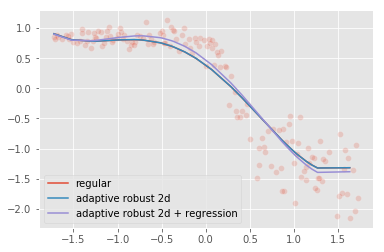

5


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 254.32it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -55.15425782428193
Laplace Log Likelihood:  -55.624018902818676
Adaptive Log Likelihood:  -13.125948
Ada+reg Log Likelihood :  -0.14216423


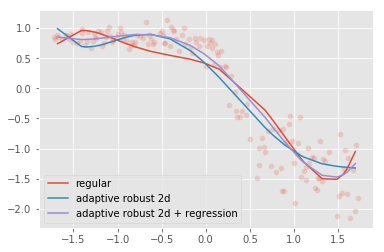

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 245.22it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -51.62024904552712
Laplace Log Likelihood:  -55.67413588932632
Adaptive Log Likelihood:  -14.285194
Ada+reg Log Likelihood :  -18.177177


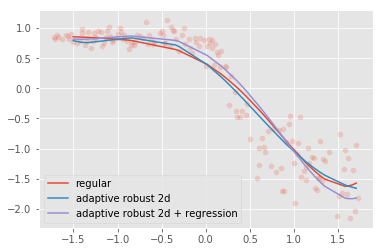

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 254.32it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -46.365762683037325
Laplace Log Likelihood:  -45.792355233661226
Adaptive Log Likelihood:  -9.808943
Ada+reg Log Likelihood :  -5.084284


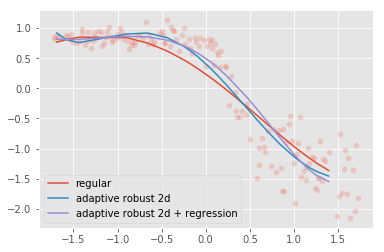

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 252.65it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -46.98402940408181
Laplace Log Likelihood:  -43.20904852386525
Adaptive Log Likelihood:  -4.5788374
Ada+reg Log Likelihood :  3.2125893


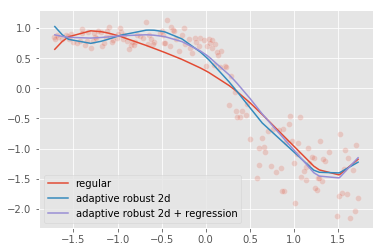

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 258.26it/s]


Polynomial degree  5
Gaussian Log Likelihood:  -51.72943516234433
Laplace Log Likelihood:  -52.890489887681525
Adaptive Log Likelihood:  -11.689543
Ada+reg Log Likelihood :  5.338416


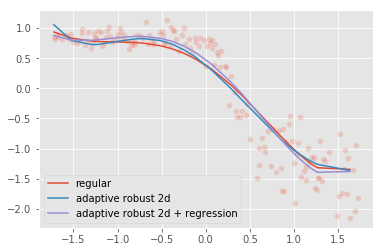

6


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 255.49it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -55.456855642155546
Laplace Log Likelihood:  -55.52493532562691
Adaptive Log Likelihood:  -12.498377
Ada+reg Log Likelihood :  0.11097908


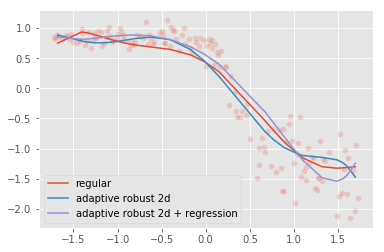

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 252.53it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -51.37160988919395
Laplace Log Likelihood:  -55.716071589940555
Adaptive Log Likelihood:  -13.940289
Ada+reg Log Likelihood :  -15.189565


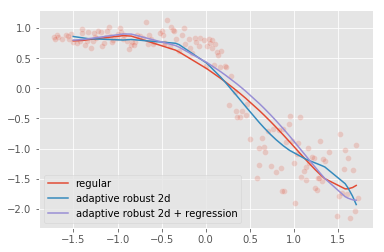

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 254.71it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -46.63771451955436
Laplace Log Likelihood:  -46.67038582013912
Adaptive Log Likelihood:  -16.12507
Ada+reg Log Likelihood :  -8.332744


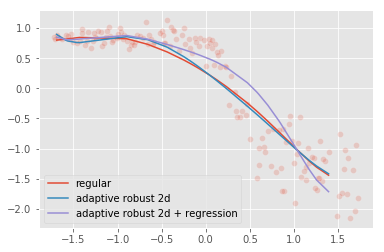

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 242.60it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -46.68913958997455
Laplace Log Likelihood:  -43.08189952045565
Adaptive Log Likelihood:  -10.854638
Ada+reg Log Likelihood :  0.19095421


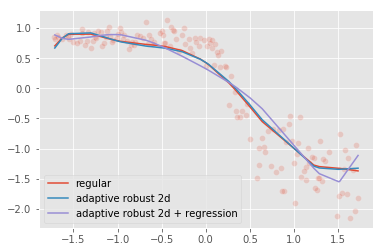

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 231.27it/s]


Polynomial degree  6
Gaussian Log Likelihood:  -51.27093046443816
Laplace Log Likelihood:  -52.4543770309471
Adaptive Log Likelihood:  -12.629839
Ada+reg Log Likelihood :  3.611494


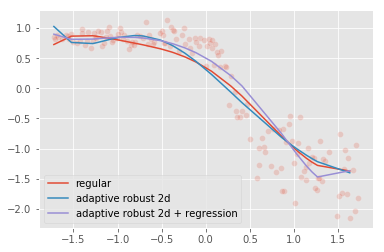

7


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 204.16it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -55.53054604479219
Laplace Log Likelihood:  -56.33507344052066
Adaptive Log Likelihood:  -14.382132
Ada+reg Log Likelihood :  -1.4864349


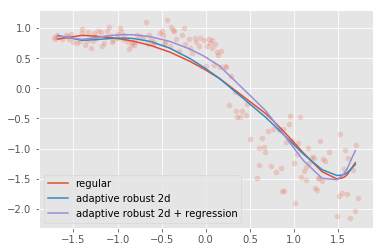

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 242.95it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -52.008960115921624
Laplace Log Likelihood:  -55.419683987492995
Adaptive Log Likelihood:  -14.790223
Ada+reg Log Likelihood :  -21.678642


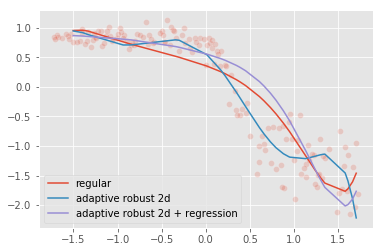

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 241.08it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -46.77978066610691
Laplace Log Likelihood:  -47.04448377149011
Adaptive Log Likelihood:  -22.579903
Ada+reg Log Likelihood :  -7.0240803


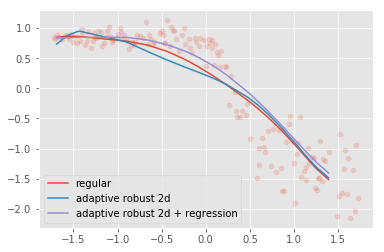

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 248.02it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -46.75672258072773
Laplace Log Likelihood:  -43.71417264752642
Adaptive Log Likelihood:  -12.554412
Ada+reg Log Likelihood :  2.5656567


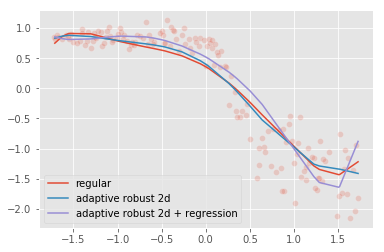

100%|███████████████████████████████████████| 500/500 [00:01<00:00, 250.63it/s]


Polynomial degree  7
Gaussian Log Likelihood:  -51.119792292218136
Laplace Log Likelihood:  -52.67974967504569
Adaptive Log Likelihood:  -11.644166
Ada+reg Log Likelihood :  1.2380791


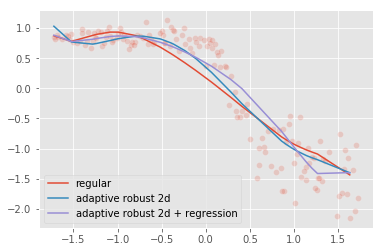

In [103]:
from sklearn.metrics import mean_absolute_error

x, y = torch.Tensor(trX), torch.Tensor(trY)
x_noout, y_noout = torch.Tensor(trXnoout), torch.Tensor(trYnoout)
outliers = True

if dataset == 'lidar':
    x_out1 = np.random.uniform(low=-0.8, high=-0.5, size=(10,))
    y_out1 = np.random.uniform(low=-1.5, high=-1, size=(10,))
    x_out2 = np.random.uniform(low=1, high=1.5, size=(10,))
    y_out2 = np.random.uniform(low=0.5, high=1, size=(10,))
    
if dataset == 'motor':
    x_out1 = np.random.uniform(low=-1.5, high=-1, size=(10,))
    y_out1 = np.random.uniform(low=-1, high=-1.4, size=(10,))
    x_out2 = np.random.uniform(low=1.3, high=1.5, size=(10,))
    y_out2 = np.random.uniform(low=-1, high=-1.5, size=(10,))

n_splits = 5

cv = KFold(n_splits=n_splits, shuffle=True, random_state=3)

reg_degrees = 7

table = np.zeros((reg_degrees, 4))
tablemae = np.zeros((reg_degrees, 4))

for i in range(reg_degrees):
    
    reg_degree = i+1
    print(reg_degree)
    
    
    gauss_log_likelihoods = np.zeros((n_splits,1))
    laplace_log_likelihoods = np.zeros((n_splits,1))
    ada_log_likelihoods = np.zeros((n_splits,1))
    adaloc_log_likelihoods = np.zeros((n_splits,1))
    
    gauss_maes = np.zeros((n_splits,1))
    laplace_maes = np.zeros((n_splits,1))
    ada_maes = np.zeros((n_splits,1))
    adaloc_maes = np.zeros((n_splits,1))
    
    j = 0

    for train_index, test_index in cv.split(x):
            
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]
        
        if outliers:
            x_outs = np.concatenate([x_out1[j*2:j*2+2], x_out2[j*2:j*2+2]])
            y_outs = np.concatenate([y_out1[j*2:j*2+2], y_out2[j*2:j*2+2]])
            X_train = torch.cat((X_train, torch.Tensor(x_outs)))
            y_train = torch.cat((y_train, torch.Tensor(y_outs)))
            

        # define regression model
        lr = PolyRegression(reg_degree)

        # regular loss training - gaussian
        lr = PolyRegression(reg_degree)
        reg_fit = train_regular(lr, X_train, y_train, gaussian, epoch=500, learning_rate=0.01, verbose=False)
        
        # regular loss training - laplace
        lr = PolyRegression(reg_degree)
        reg_fit_laplace = train_regular(lr, X_train, y_train, laplace, epoch=500, learning_rate=0.01, verbose=False)

        # ada loss training
        lr = PolyRegression(reg_degree)
        ada_fit, alpha, scale = train_adaptive(lr, X_train, y_train, learning_rate=0.01, epoch=500, verbose=False)

        # adalocal loss training
        lr = PolyRegression(reg_degree)
        alpha_model = PolyRegression(2, init_zeros=True)
        scale_model = PolyRegression(2, init_zeros=True)
        ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, X_train, y_train, 
                                                                   learning_rate=0.01, epoch=500, verbose=False)
                

        sortedx, idxX = torch.sort(X_val)
        y2 = reg_fit(sortedx).detach().view(-1)
        ylap = reg_fit_laplace(sortedx).detach().view(-1)
        yar = ada_fit(sortedx).detach().view(-1)
        yalr = ada_loc_fit(sortedx).detach().view(-1)
        alphas = torch.exp(alpha_model(sortedx).view(-1))
        scales = torch.exp(scale_model(sortedx).view(-1))
        
        # test on non outliers 
        # include modal regression
        
        gauss_log_lik = gaussian.loglikelihood(y2.numpy().flatten()-y_val.numpy().flatten())
        laplace_log_lik = laplace.loglikelihood(ylap.numpy().flatten()-y_val.numpy().flatten())
        ada_log_lik = adaptive.loglikelihood(yar-y_val[idxX], alpha, scale)
        adaloc_log_lik = adaptive.loglikelihood(yalr-y_val[idxX], alphas, scales)
        
        gauss_mae = mean_absolute_error(y_val.numpy().flatten(), y2.numpy().flatten())
        laplace_mae = mean_absolute_error(y_val.numpy().flatten(), ylap.numpy().flatten())
        ada_mae = mean_absolute_error(y_val.numpy().flatten(), yar.numpy().flatten())
        adaloc_mae = mean_absolute_error(y_val.numpy().flatten(), yalr.numpy().flatten())
        
        gauss_log_likelihoods[j,:] = gauss_log_lik
        laplace_log_likelihoods[j,:] = laplace_log_lik
        ada_log_likelihoods[j,:] = ada_log_lik
        adaloc_log_likelihoods[j,:] = adaloc_log_lik
        
        gauss_maes[j,:] = gauss_mae
        laplace_maes[j,:] = laplace_mae
        ada_maes[j,:] = ada_mae
        adaloc_maes[j,:] = adaloc_mae

        print('Polynomial degree ', reg_degree)
        print('Gaussian Log Likelihood: ', gaussian.loglikelihood(y2.numpy().flatten()-y_val.numpy().flatten()))
        print('Laplace Log Likelihood: ', laplace.loglikelihood(ylap.numpy().flatten()-y_val.numpy().flatten()))
        print('Adaptive Log Likelihood: ', adaptive.loglikelihood(yar-y_val[idxX], alpha, scale))
        print('Ada+reg Log Likelihood : ', adaptive.loglikelihood(yalr-y_val[idxX], alphas, scales))
        
        sns.scatterplot(trX, trY, alpha=0.2)
        sns.lineplot(sortedx.detach().numpy(), y2.detach().numpy().flatten(), label='regular')
        sns.lineplot(sortedx.detach().numpy(), yar.detach().numpy().flatten(), label='adaptive robust 2d')
        sns.lineplot(sortedx.detach().numpy(), yalr.detach().numpy().flatten(), label='adaptive robust 2d + regression')
        plt.show()
        
        j += 1
    
    gauss_log_likelihood_mean = np.mean(gauss_log_likelihoods)
    laplace_log_likelihood_mean = np.mean(laplace_log_likelihoods)
    ada_log_likelihood_mean = np.mean(ada_log_likelihoods)
    adaloc_log_likelihood_mean = np.mean(adaloc_log_likelihoods)
    
    gauss_mae_mean = np.mean(gauss_maes)
    laplace_mae_mean = np.mean(laplace_maes)
    ada_mae_mean = np.mean(ada_maes)
    adaloc_mae_mean = np.mean(adaloc_maes)
    
    table[i, 0] = gauss_log_likelihood_mean
    table[i, 1] = laplace_log_likelihood_mean
    table[i, 2] = ada_log_likelihood_mean
    table[i, 3] = adaloc_log_likelihood_mean
    
    tablemae[i, 0] = gauss_mae_mean
    tablemae[i, 1] = laplace_mae_mean
    tablemae[i, 2] = ada_mae_mean
    tablemae[i, 3] = adaloc_mae_mean
    
    
    

In [104]:
#np.set_printoptions(suppress=True,
#   formatter={'float_kind':'{:f}'.format})

np.savetxt('lidar_loglike.csv', np.round(table, 2), delimiter = ',')

print(np.round(table, 2))

np.savetxt('lidar_mae.csv', np.round(tablemae, 2), delimiter = ',')

print(np.round(tablemae, 2))




[[-49.560000 -51.890000 -21.370000 -23.240000]
 [-50.340000 -51.540000 -16.920000 -6.590000]
 [-50.340000 -51.330000 -13.920000 -6.710000]
 [-50.650000 -50.700000 -12.900000 -3.530000]
 [-50.370000 -50.640000 -10.700000 -2.970000]
 [-50.290000 -50.690000 -13.210000 -3.920000]
 [-50.440000 -51.040000 -15.190000 -5.280000]]
[[0.980000 0.990000 0.980000 0.960000]
 [0.970000 0.990000 0.970000 0.970000]
 [0.950000 0.980000 0.970000 0.990000]
 [0.950000 0.960000 0.950000 0.970000]
 [0.960000 0.960000 0.950000 0.970000]
 [0.950000 0.960000 0.960000 0.960000]
 [0.960000 0.970000 0.970000 0.970000]]


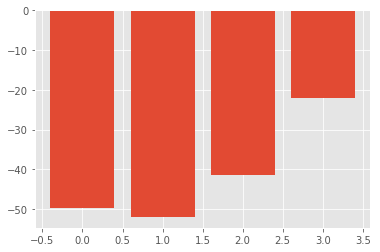

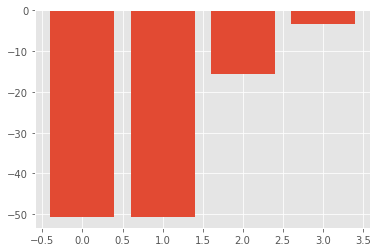

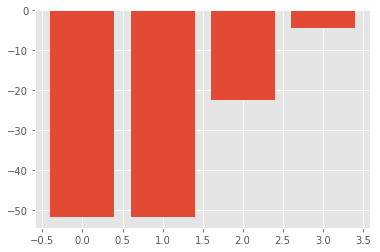

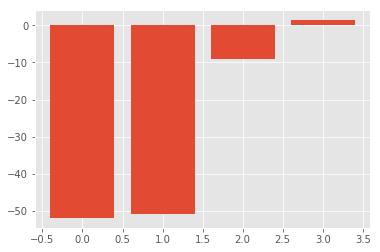

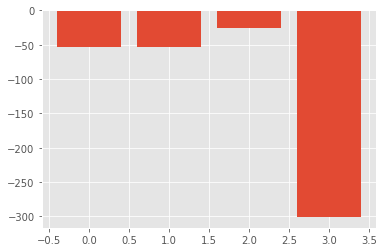

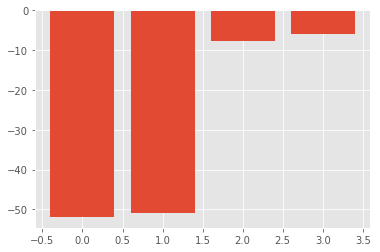

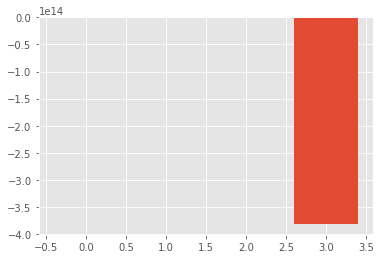

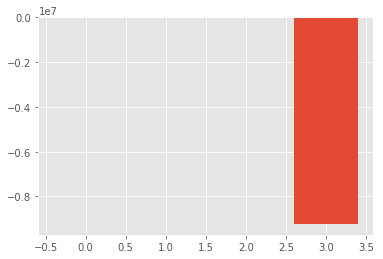

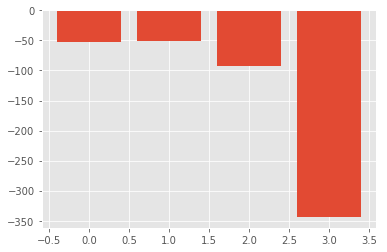

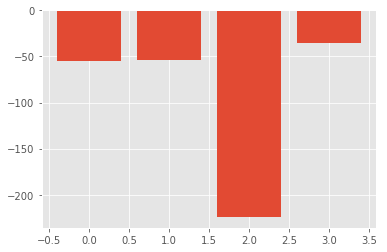

In [79]:
for i in range(table.shape[0]):
    plt.bar([0,1,2,3], table[i,:])
    plt.show()

# GP baseline

In [10]:
# GP regression
x, y = torch.Tensor(trX), torch.Tensor(trY)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x, y, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 50
for i in tqdm(range(training_iter)):
    optimizer.zero_grad()
    output = model(x)
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()
    


100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 29.08it/s]


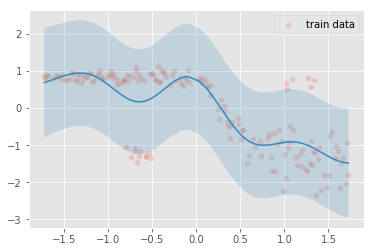

In [12]:
sortedx, idxX = torch.sort(x)
sortedy = y[idxX]

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(sortedx))
    lower, upper = observed_pred.confidence_region()
    sns.scatterplot(trX, trY, label='train data', alpha=0.2)
    sns.lineplot(sortedx, observed_pred.mean.numpy(), color=palette[1])
    plt.fill_between(sortedx.detach(), lower.numpy(), upper.numpy(), alpha=0.2)

In [13]:
mll(observed_pred, y)*len(y)

tensor(-279.5622, grad_fn=<MulBackward0>)